# Bike sharing prediction NN project

In this project a neural network is used to predict daily bike rental ridership from a dataset with the number of riders for each hour of each day from January 1 2011 to December 31 2012. 

Some code was provided by Udacity but the implementation of the neural network was left up to the student. Student inputs are marked with "input start" and "input end".



---
## 1.- Import necessary libraries

In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unittest
import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
## 2.- Load and visualize the data

First, the data is loaded, prepared and visualized to take a look at it's structure.

In [2]:
# Load data

data_path = 'data.csv'
rides = pd.read_csv(data_path)

# Visualize data structure

rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


---
## 3.- Check out the data

As commented above, this dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column as shown in the table above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) Hourly rentals are displyed here. The data is complex. The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Information about temperature, humidity, and windspeed are also provided as they likely affect the number of riders. The model will attempt to capture all of this complexity.

<AxesSubplot:xlabel='dteday'>

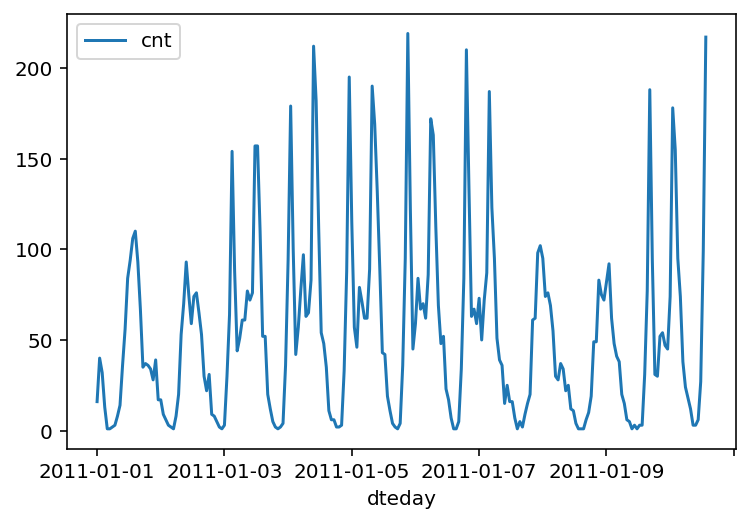

In [3]:
# Plot hourly rides during a week

rides[:24*10].plot(x='dteday', y='cnt')

---
## 4.- Create dummy variables

The dataset has some categorical variables like season, weather, month. To include these in the model, binary dummy variables are needed. To obtain the, Panda's `get_dummies()` function was used.

In [4]:
# Create dummie variables

dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']

data = rides.drop(fields_to_drop, axis=1)

# Display new dataset structure

data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


---
## 5.- Scaling target variables

To make training the network easier, the continuous variables were standardized such that they had zero mean and a standard deviation of 1. Scaling factors were saved so they could be unscaled when using the network for predictions.

In [5]:
# Save data for approximately the last 21 days

test_data = data[-21*24:]

# Remove the test data from the data set

data = data[:-21*24]
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

# Store scalings in a dictionary for later reconversion

scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std
    test_data.loc[:, each] = (test_data[each] - mean)/std

---
## 6.- Splitting the data into training, testing, and validation sets

Data for the last approximately 21 days was saved to use as a test set after training the network. This set will be used to make predictions and compare them with the actual number of riders.

Data was split into two sets, one for training and one for validating as the network is being trained. Since this is time series data, training was performed on historical data to try to predict future data (the validation set).

In [6]:
# Separate the data into features and targets

target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

# Hold out the last 60 days or so of the remaining data as a validation set

train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

---
## 7.- Build the network

Below the network is built, implementing both the forward pass and backwards pass through the network. Also the required hyperparameters are set (learning rate, number of hidden units, number of training passes).

<img src="neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer uses the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$.  

In [7]:
# Define neural network

class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        
        # Set number of nodes in input, hidden and output layers.
        
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        # INPUT START
        
        # Define self.activation_function
       
        self.activation_function = lambda x : 1 / (1 + np.exp(-x))  # Replace 0 with your sigmoid calculation.
        
        # INPUT END
                    
    # Define train function
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        
        for X, y in zip(features, targets):
            
            # INPUT START
            
            # Implement forward pass function
            
            final_outputs, hidden_outputs = self.forward_pass_train(X)  
            
            # Implement backproagation function
            
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(final_outputs, hidden_outputs, X, y, 
                                                                        delta_weights_i_h, delta_weights_h_o)
        
            # INPUT END
        
        self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)


    # INPUT START
    
    # Define forward pass function
    
    def forward_pass_train(self, X):
        ''' 
            Arguments
            ---------
            X: features batch

        '''
        
        # Hidden layer
        
        hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

        # Output layer
        
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer
        
        return final_outputs, hidden_outputs

    # Define backpropagation function
    
    def backpropagation(self, final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o):
        '''         
            Arguments
            ---------
            final_outputs: output from forward pass
            y: target (i.e. label) batch
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers

        '''
        # Output error
        
        error = y - final_outputs # Output layer error is the difference between desired target and actual output.

        # Calculate hidden layer's contribution to the error
        
        hidden_error = np.dot(self.weights_hidden_to_output, error)
        
        # Calculate backpropagated error terms
        
        output_error_term = error
        
        hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)
        
        # Weight step (input to hidden)
        
        delta_weights_i_h += hidden_error_term  * X[:, None]
        
        # Weight step (hidden to output)
        
        delta_weights_h_o += output_error_term * hidden_outputs[:, None]
        
        return delta_weights_i_h, delta_weights_h_o

    # Define update_weights function for gradient descent
    
    def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):
        '''          
            Arguments
            ---------
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers
            n_records: number of records

        '''
        
        # Update the weights with gradient descent step
        
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records # update input-to-hidden weights with gradient descent step

    # Define run function
    
    def run(self, features):
        ''' 
            Runs a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        # Hidden layer
        
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # Output layer
        
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs

# Set hyperparameters

iterations = 2000
learning_rate = 1.1
hidden_nodes = 7
output_nodes = 1

# Define mean square error function

def MSE(y, Y):
    return np.mean((y-Y)**2)

# INPUT END

---
## 8.- Unit tests

Unit tests provided were ran to check the correctness of the network implementation before training.

In [10]:
# Unit tests

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

# Define TestMethods class

class TestMethods(unittest.TestCase):
    
    ### Define unit tests for data loading
    
    # Test that file path to dataset has been unaltered    
    
    def test_data_path(self):
        self.assertTrue(data_path.lower() == 'data.csv')
    
    # Test that data frame loaded    
    
    def test_data_loaded(self):
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ###Define unit tests for network functionality
    
    # Test that the activation function is a sigmoid

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    # Test that weights are updated correctly on training
        
    def test_train(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    # Test correctness of run method

    def test_run(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.005s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

---
## 9.- Training and validating the network

Below the network is trained and validated using the model and hyperparameters set above. Losses are plotted to evaluate the training process. Multiple trainings were performed in order to fine tune the hyperparameters.

In [12]:
# Network training and validation

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}

for ii in range(iterations):
    
    # Go through a random batch of 128 records from the training data set
    
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']
                             
    network.train(X, y)
    
    # Print out the training progress
    
    train_loss = MSE(np.array(network.run(train_features)).T, train_targets['cnt'].values)
    val_loss = MSE(np.array(network.run(val_features)).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.090 ... Validation loss: 0.182

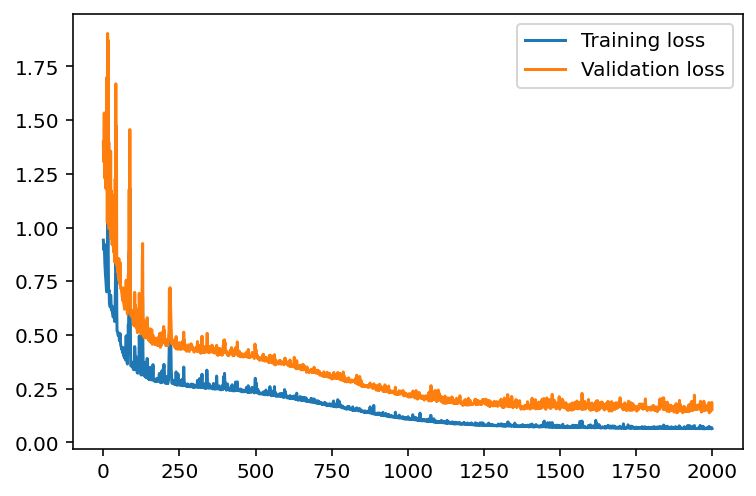

In [59]:
# Plot training and validation losses

plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

---
## 10.- Check out predictions

Here, the test data is used to evaluate how well the network is modeling the data.

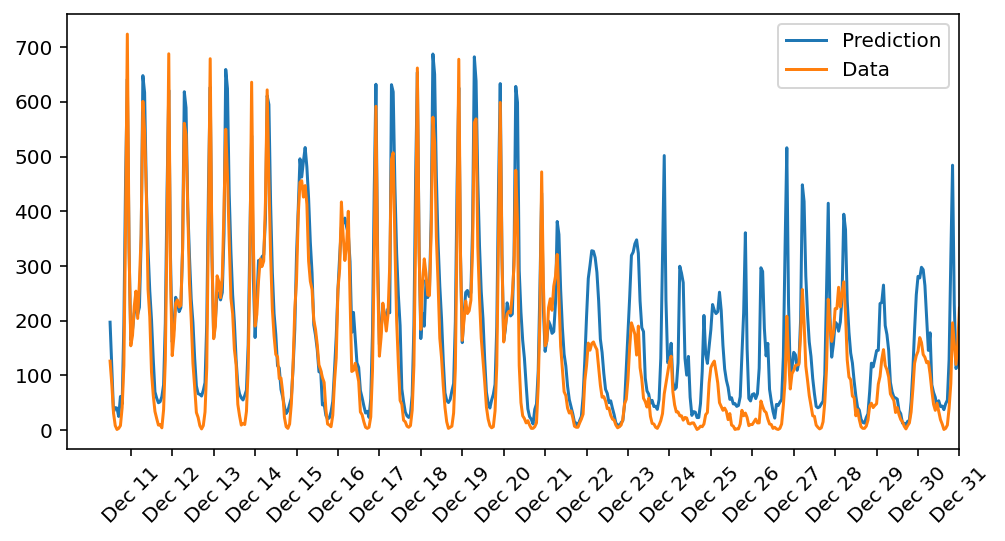

In [60]:
# Plot network predictions against test data

fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = np.array(network.run(test_features)).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

---
## 11.- Discussion
 
The model seems to make accurate predictions until it reaches the christmas hollidays. There is less data for the model to train on for holidays, and different the data for different hollidays (christams, easter and so on) is agregated, which can result in less accurate predictions for these times of the year.

Obtaining more data to train on and separating the data for different hollidays could improve the models performance.